In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

from Chempy.parameter import ModelParameters

import sbi.utils as utils

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

/export/home/bguenes/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Hello World!")



Hello World!


In [7]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [5]:
# ----- Load posterior -----
with open('data/posterior_SNPE_torch.pickle', 'rb') as f:
    posterior = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/posterior_SNPE_torch.pickle'

In [4]:
# ----- Load the NN -----
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x
    
model = Model_Torch()
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval();

# Setup priors
The inputs to the model are drawn from a fixed set of global galaxy parameters (slope of the IMF & Rate of Type Ia Supernove) and a set of local star parameters.

In [5]:
local_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

global_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[:2]],
    validate_args=False)

# Simulate data
With the set global priors and for each $N_{\rm stars}$ a set of local priors, we can simulate the data with the Neural Network.

In [6]:
N_stars = 1000

stars = local_GP.sample((N_stars,))
global_params = global_GP.sample((1,))

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

In [7]:
# ----- Simulate abundances -----
start = t.time()
abundances = model(stars)   
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 1000 stars: 0.017 s


Run the sbi inference with the simulated data and save the output for all simulations.

In [8]:
alpha_IMF = []
log10_N_Ia = []
simulations = 1000

start = t.time()
for i in tqdm(range(len(abundances))):
    alpha, N_Ia = posterior.sample((simulations,), x=abundances[i], show_progress_bars=False)[:,0:2].T
    alpha_IMF.append(alpha)
    log10_N_Ia.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF = np.array(alpha_IMF).ravel()
log10_N_Ia = np.array(log10_N_Ia).ravel()

100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]

Time to run 1000 simulations for 1000 stars: 282.454 s


In [12]:
# save the data
np.save('data/alpha_IMF.npy', alpha_IMF)
np.save('data/log10_N_Ia.npy', log10_N_Ia)

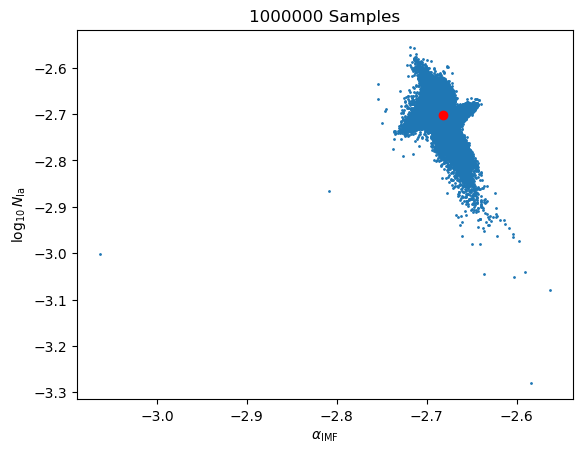

In [9]:
plt.scatter(alpha_IMF, log10_N_Ia, s=1)
plt.xlabel(r'$\alpha_{\rm IMF}$')
plt.ylabel(r'$\log_{10} N_{\rm Ia}$')
plt.scatter(global_params[0][0], global_params[0][1], color='r')
plt.title(f'{len(alpha_IMF)} Samples');

In [22]:
def plot_2d_hist(x1, x2, x_true, name):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    
    x1_mean = np.mean(x1)
    x1_std = np.std(x1)
    x1_min = x1_mean - 10 * x1_std
    x1_max = x1_mean + 10 * x1_std
    
    lin1 = np.linspace(x1_min, x1_max, 1000)
    p1 = norm.pdf(lin1, x1_mean, x1_std)
    
    ax[0].hist(x1, bins=500, density=True, alpha=0.6, color='g')
    ax[0].plot(lin1, p1, 'k', linewidth=2)
    ax[0].axvline(x=x_true[0], color='r', linestyle='dashed', linewidth=2)
    ax[0].set_title(fr"{name[0]}: {x_true[0]:.3f}"
                    "\n"
                    fr"$\mu$: {x1_mean:.3f} $\sigma$: {x1_std:.3f}")
    ax[0].set_xlim(x1_min, x1_max)
    
    x2_mean = np.mean(x2)
    x2_std = np.std(x2)
    x2_min = x2_mean - 10 * x2_std
    x2_max = x2_mean + 10 * x2_std
    
    lin2 = np.linspace(x2_min, x2_max, 1000)
    p2 = norm.pdf(lin2, x2_mean, x2_std)
        
    ax[1].hist(x2, bins=500, density=True, alpha=0.6, color='g')
    ax[1].plot(lin2, p2, 'k', linewidth=2)
    ax[1].axvline(x=x_true[1], color='r', linestyle='dashed', linewidth=2)
    ax[1].set_title(fr"{name[1]}: {x_true[1]:.3f}"
                    "\n"
                    fr"$\mu$: {x2_mean:.3f} $\sigma$: {x2_std:.3f}")
    ax[1].set_xlim(x2_min, x2_max)
    
    fig.suptitle(f'{int(len(x1)/simulations)} Stars', fontsize=30)
    plt.tight_layout()
    plt.show()

1000 simulations for each star


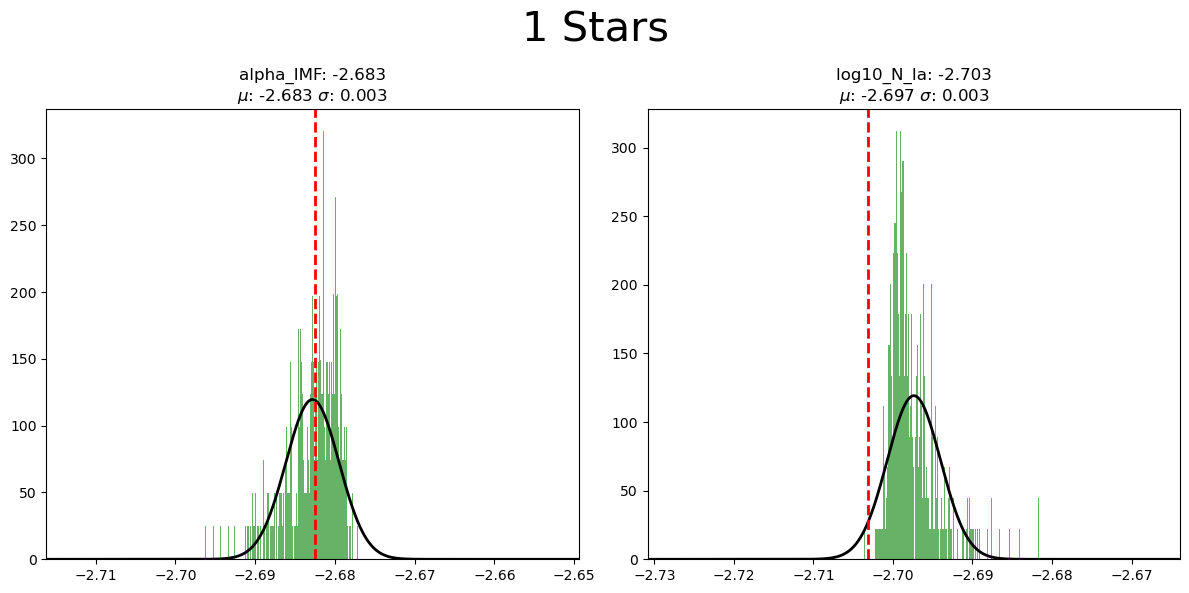

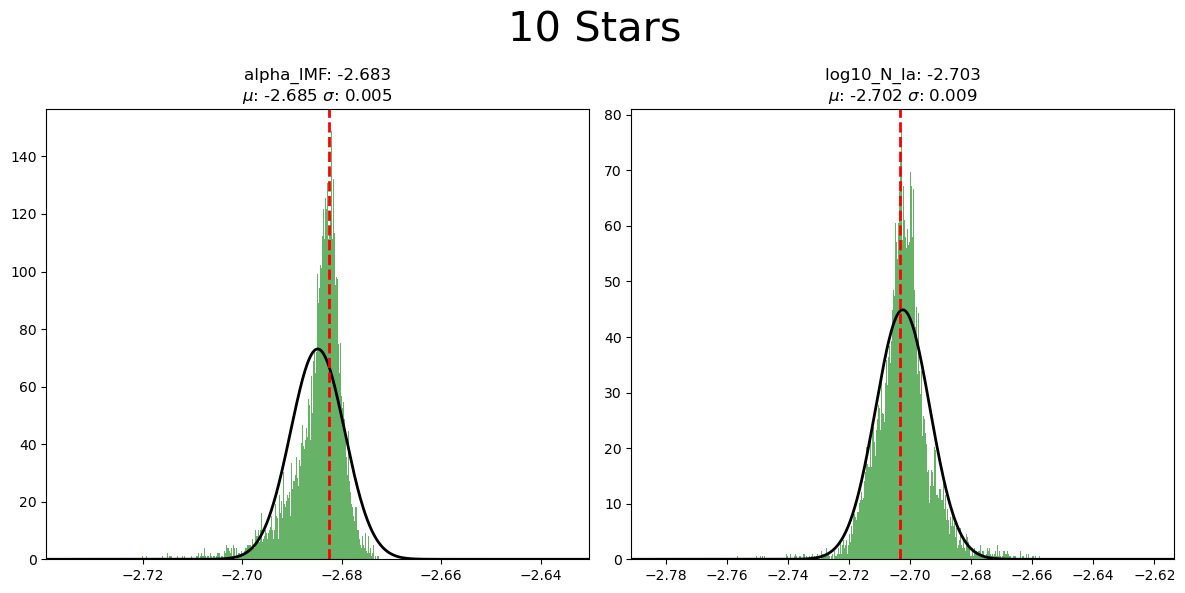

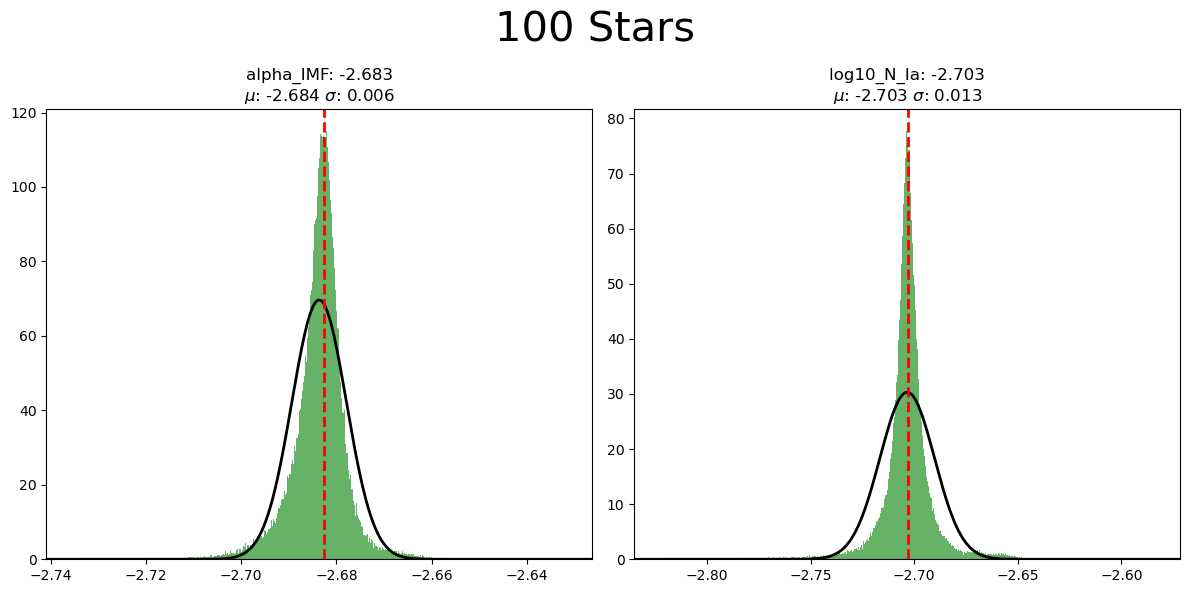

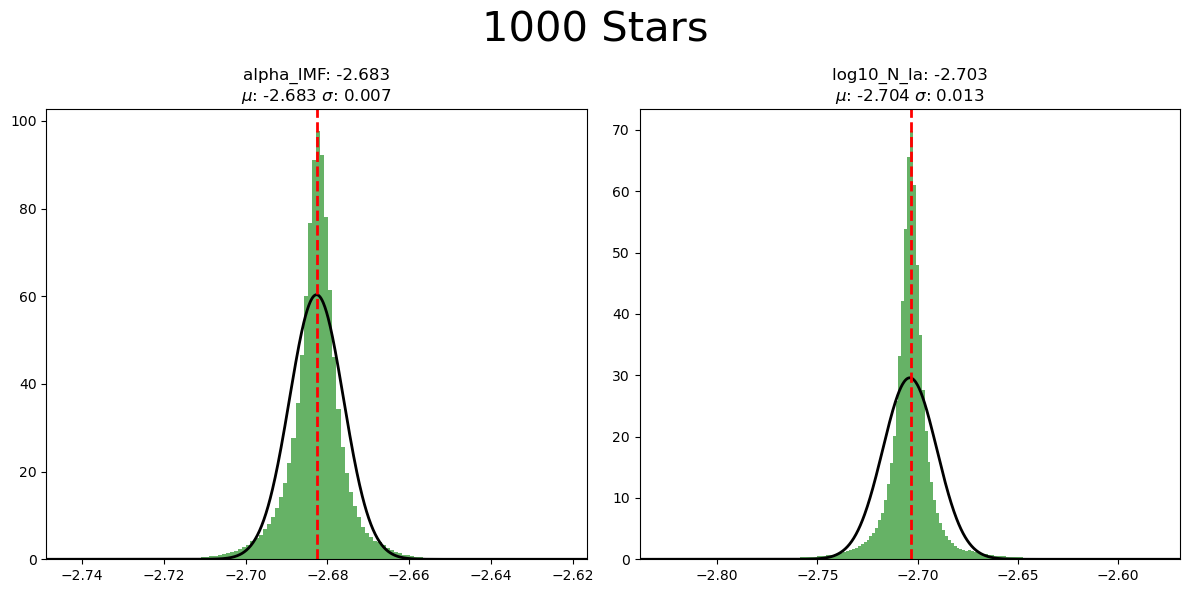

In [11]:
sims = np.array([1, 10, 100, 1000]) * simulations
print(f"{simulations} simulations for each star")
for i in sims:
    plot_2d_hist(alpha_IMF[0:i], log10_N_Ia[0:i], global_params[0], ['alpha_IMF', 'log10_N_Ia'])

# Analysis with 16 simulations
Use 16 simulations for each star, to compare results to paper.

In [19]:
N_stars = 1000000

stars = local_GP.sample((N_stars,))
global_params = global_GP.sample((1,))

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

# ----- Simulate abundances -----
start = t.time()
abundances = model(stars)   
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

alpha_IMF = []
log10_N_Ia = []
simulations = 16

start = t.time()
for i in tqdm(range(len(abundances))):
    alpha, N_Ia = posterior.sample((simulations,), x=abundances[i], show_progress_bars=False)[:,0:2].T
    alpha_IMF.append(alpha)
    log10_N_Ia.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')


Time to create data for 1000000 stars: 0.625 s


  0%|          | 458/1000000 [00:01<59:09, 281.57it/s]  WARNING:root:Only 0.399% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    -24 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  1%|          | 5945/1000000 [00:28<1:07:21, 245.94it/s]WARNING:root:Only 0.559% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    -40 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  1%|          | 12461/1000000 [01:03<1:03:12, 260.42it/s]WARNING:root:Only 0.729% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    -57 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  6%|▌         | 61

KeyboardInterrupt: 

16 simulations for each star


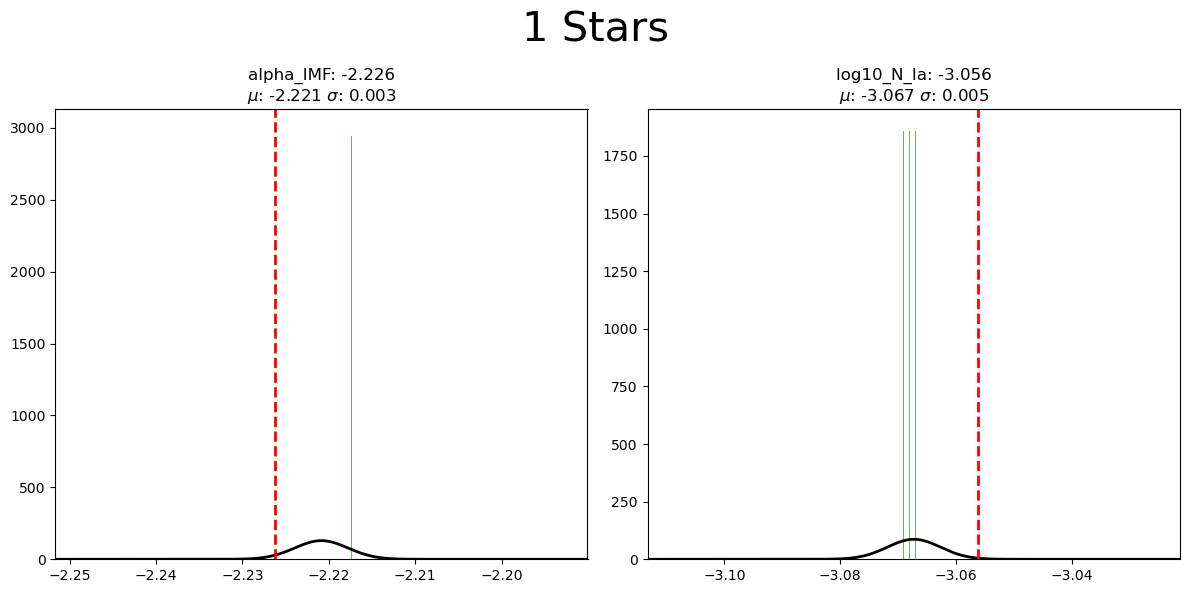

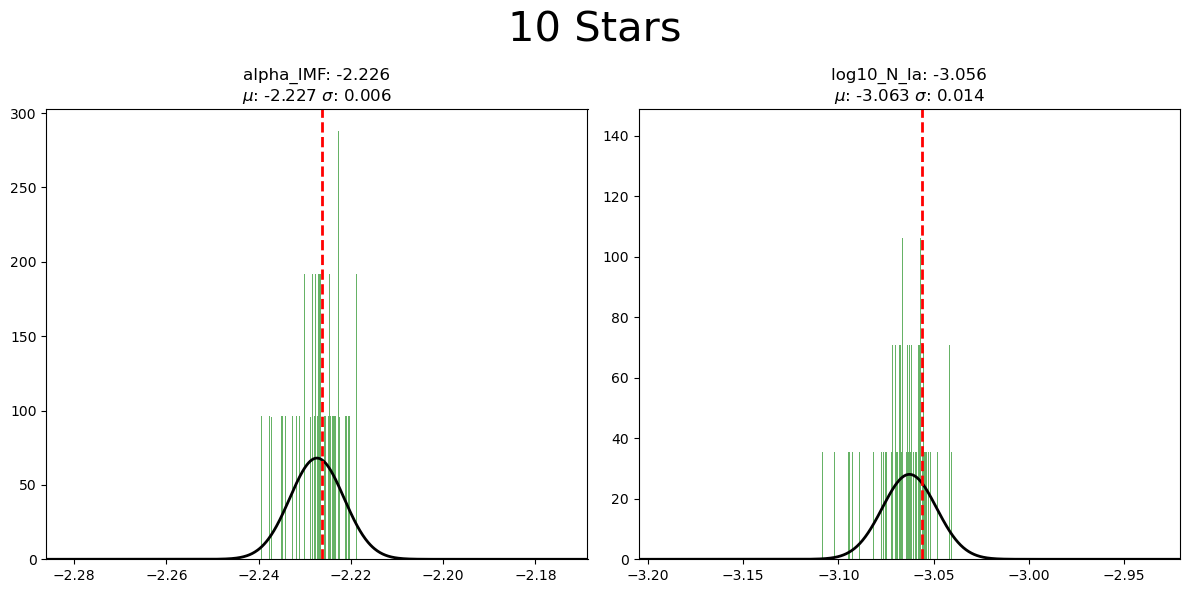

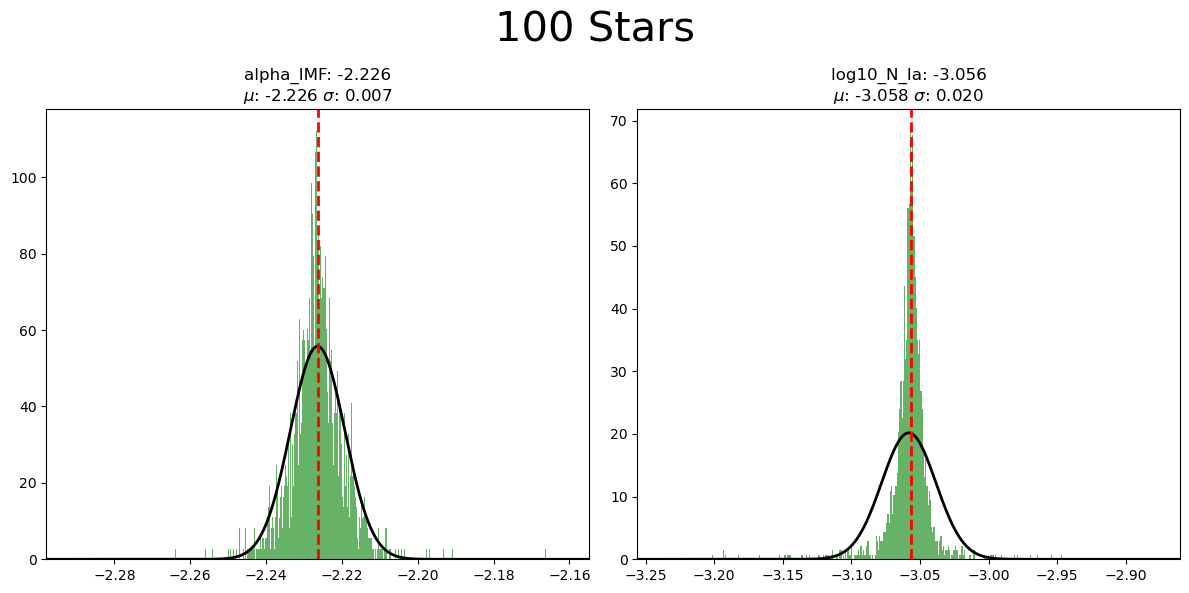

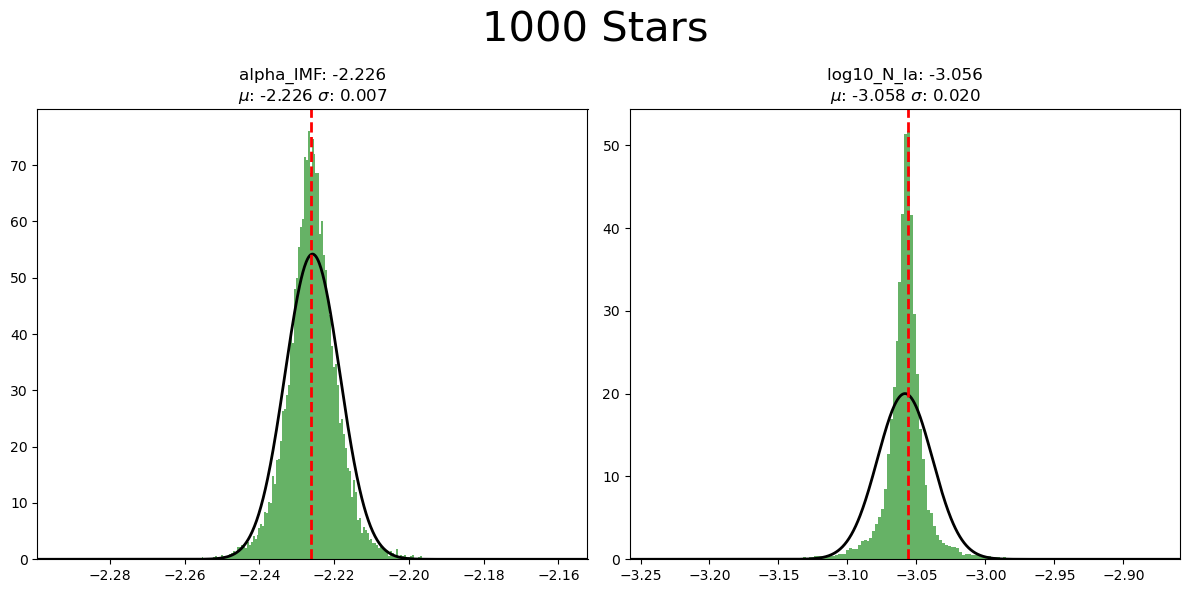

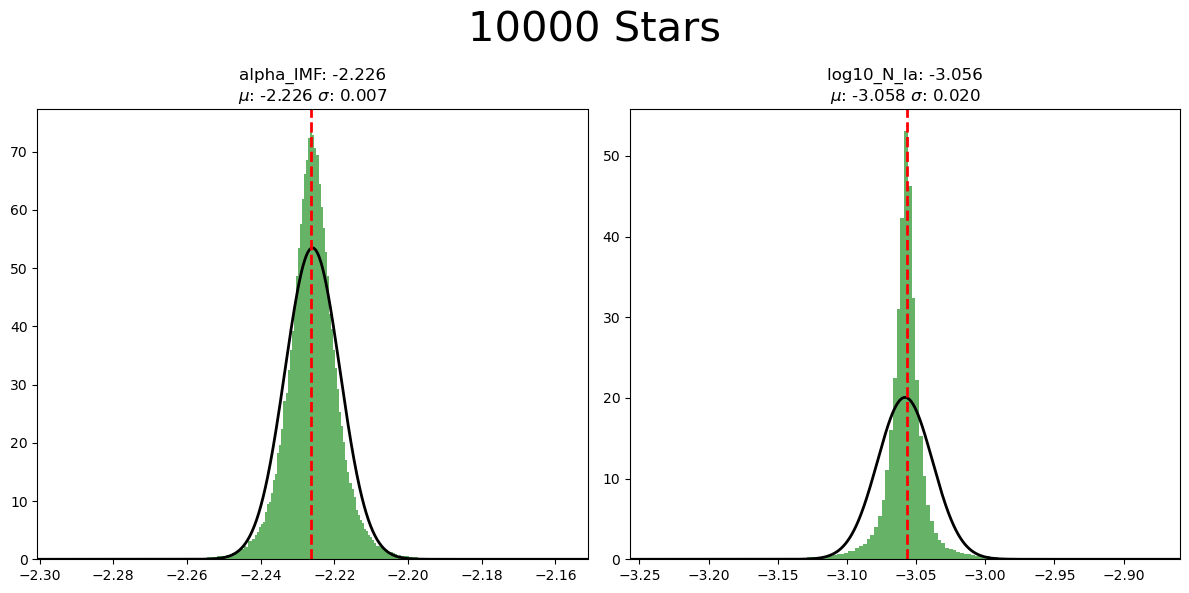

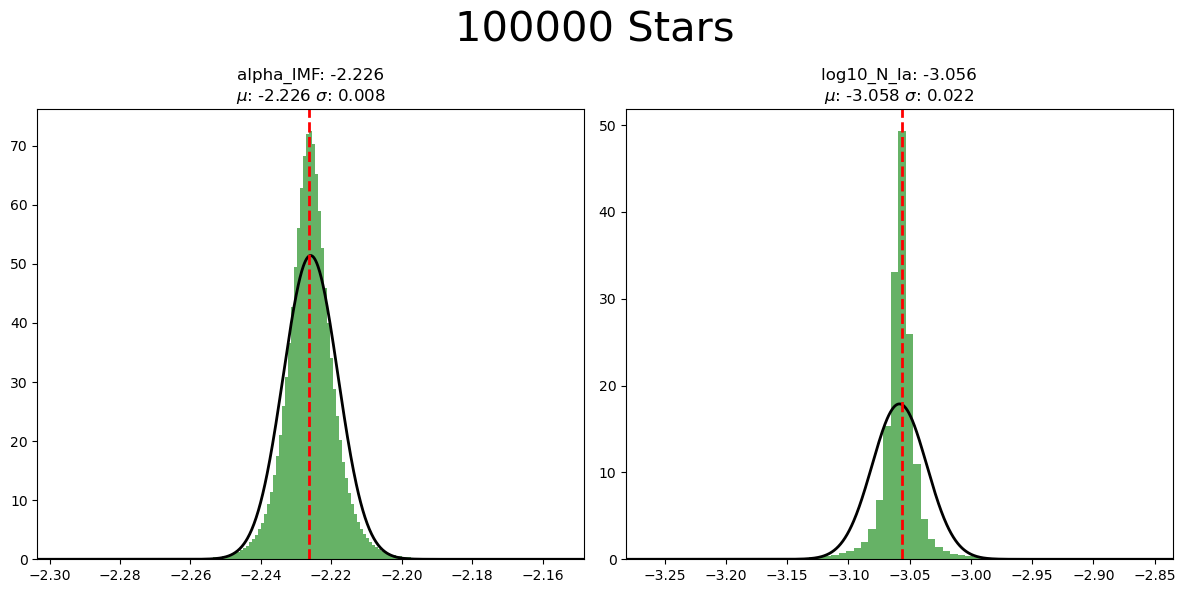

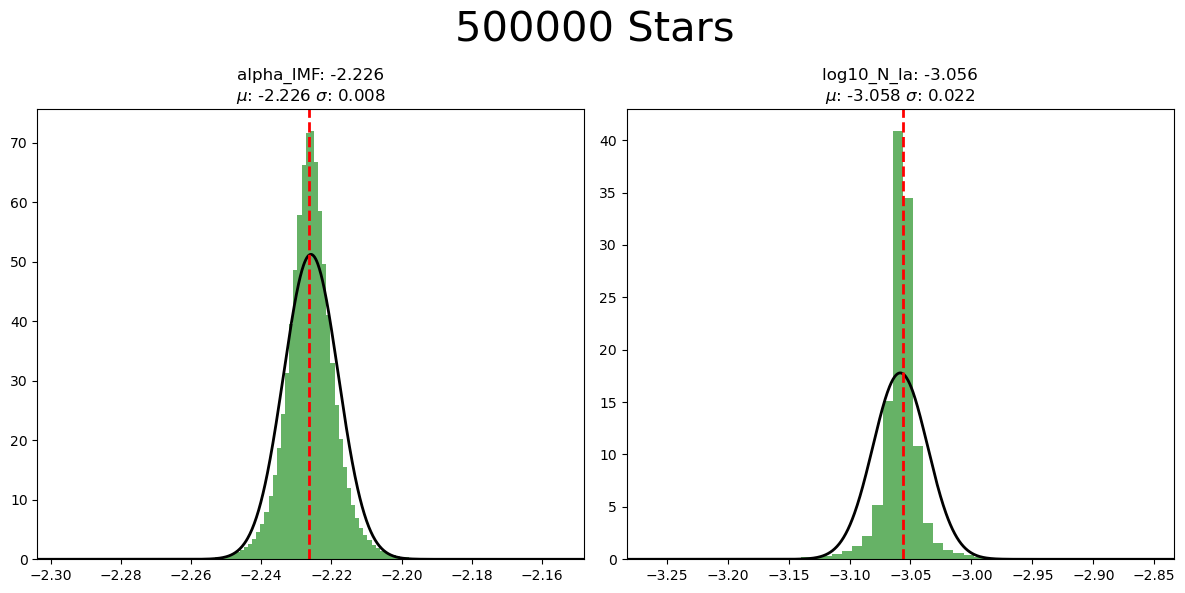

In [23]:
alpha_IMF = np.array(alpha_IMF).ravel()
log10_N_Ia = np.array(log10_N_Ia).ravel()

sims = np.array([1, 10, 100, 1000, 10000, 100000, 500000]) * simulations
print(f"{simulations} simulations for each star")
for i in sims:
    plot_2d_hist(alpha_IMF[0:i], log10_N_Ia[0:i], global_params[0], ['alpha_IMF', 'log10_N_Ia'])